In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

TensorFlow version: 2.18.0
Num GPUs Available: 0


[]

In [ ]:
from datetime import datetime
import requests
import concurrent.futures
from tqdm import tqdm
import os

import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, BatchNormalization, Dropout, GaussianNoise, Add, Multiply)
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW, Adam

In [ ]:
drive_folder = "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/"

files = [
    drive_folder + "scenarios_batch_technology.parquet",
    drive_folder + "scenarios_batch_financials.parquet",
    drive_folder + "scenarios_batch_healthcare.parquet",
    drive_folder + "scenarios_batch_industrials.parquet",
    drive_folder + "scenarios_batch_consumer_discretionary.parquet",
    drive_folder + "scenarios_batch_real_estate.parquet",
    drive_folder + "scenarios_batch_energy.parquet",
    drive_folder + "scenarios_batch_communication_services.parquet",
    drive_folder + "scenarios_batch_materials.parquet",
    drive_folder + "scenarios_batch_utilities.parquet",
    drive_folder + "scenarios_batch_consumer_staples.parquet"
]

option_scenarios_df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)

In [ ]:
option_scenarios_df.columns

Index(['Date', 'Ticker', 'Sector', 'shock_event', 'Close', 'S0', 'K', 'T',
       'sigma', 'r', 'moneyness', 'log_moneyness', 'RSI', 'MACD', 'Skewness',
       'Kurtosis', 'Relative_Volume', 'Volume_Change_1d', 'Volume_Change_5d',
       'delta', 'gamma', 'vega', 'theta', 'rho', 'early_exercise_prob',
       'option_type', 'price'],
      dtype='object')

In [ ]:
option_scenarios_df['sector_encoded'] = option_scenarios_df['Sector'].astype('category').cat.codes

option_scenarios_df['shock_event'] = option_scenarios_df['shock_event'].replace("None", np.nan)
option_scenarios_df['shock_event_binary'] = option_scenarios_df['shock_event'].notna().astype(int)

In [ ]:
features = [
    # Numerical Features
    'S0', 'K', 'T', 'sigma', 'r',
    'moneyness', 'log_moneyness',
    'RSI', 'MACD', 'Skewness', 'Kurtosis',
    'Relative_Volume', 'Volume_Change_1d', 'Volume_Change_5d',

    # Greeks
    'delta', 'gamma', 'vega', 'theta', 'rho',

    # Option Type
    'option_type',

    # Encoded Categorical Variables
    'sector_encoded', 'shock_event_binary'
]

target = 'price'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Apply log1p to target
option_scenarios_df[target] = np.log1p(option_scenarios_df[target])

# Prepare features and target
X = option_scenarios_df[features].copy()
y = option_scenarios_df[target].copy()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# saving the fitted scaler after fitting on X_train
joblib.dump(scaler, "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/Scalars/option_pricing_v2.pkl")

# Transform the test set using the same scaler
X_test_scaled = scaler.transform(X_test)

# Validation Split from Training
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

# Size check
print(f"Train size: {len(X_train_scaled)}")
print(f"Validation size: {len(X_val_scaled)}")
print(f"Test size: {len(X_test_scaled)}")

Train size: 16264960
Validation size: 4066240
Test size: 5082800


# Building the model

In [ ]:
def feature_attention_block(x):
    attention_scores = Dense(x.shape[-1], activation='softmax')(x)
    return Multiply()([x, attention_scores])

def residual_block(x, units):
    shortcut = Dense(units)(x)  # project shortcut to match
    x = Dense(units, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

In [ ]:
def build_american_option_pricing_model(input_dim):
    inputs = Input(shape=(input_dim,))

    x = GaussianNoise(0.01)(inputs)
    x = feature_attention_block(x)

    x = Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = residual_block(x, 512)
    x = Dropout(0.2)(x)

    x = residual_block(x, 256)

    x = Dense(128, activation='elu')(x)
    x = BatchNormalization()(x)

    output = Dense(1, activation='softplus')(x)

    model = Model(inputs=inputs, outputs=output)

    lr_schedule = CosineDecay(initial_learning_rate=5e-4, decay_steps=10000)
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

In [ ]:
input_dim = X_train_scaled.shape[1]
model = build_american_option_pricing_model(input_dim)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=8192,  # using higher batch size cause of A100
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 1.0378 - mae: 0.2571 - val_loss: 0.0450 - val_mae: 0.1308 - learning_rate: 4.5290e-04
Epoch 2/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0269 - mae: 0.0895 - val_loss: 0.0151 - val_mae: 0.0692 - learning_rate: 3.2934e-04
Epoch 3/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0161 - mae: 0.0773 - val_loss: 0.0108 - val_mae: 0.0595 - learning_rate: 1.7589e-04
Epoch 4/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0127 - mae: 0.0701 - val_loss: 0.0105 - val_mae: 0.0635 - learning_rate: 5.0362e-05
Epoch 5/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0105 - mae: 0.0640 - val_loss: 0.0070 - val_mae: 0.0447 - learning_rate: 6.0454e-08
Epoch 6/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0098 - mae: 0.0617 - val_loss: 0.0069 - val_mae: 0.0446 - learning_rate: 0.0000e+00
Epoch 7/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0098 - mae: 0.0617 - val_loss: 0.0069 - 

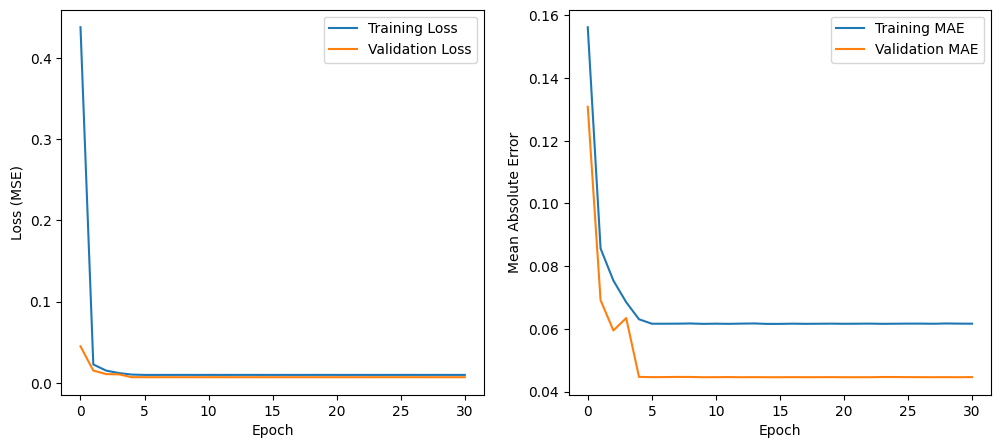

In [ ]:
# visualizing Training History
history_dict = history.history

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

158838/158838 ━━━━━━━━━━━━━━━━━━━━ 326s 2ms/step - loss: 0.0069 - mae: 0.0446
Test Loss (MSE): 0.0069
Test MAE: 0.0446
158838/158838 ━━━━━━━━━━━━━━━━━━━━ 224s 1ms/step


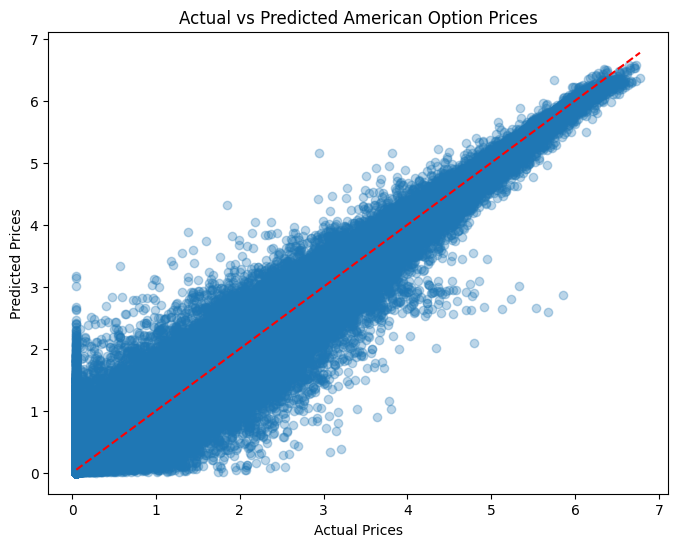

In [ ]:
# evaluating on Test Set
val_loss, val_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss (MSE): {val_loss:.4f}")
print(f"Test MAE: {val_mae:.4f}")

# predictions
predictions = model.predict(X_test_scaled).flatten()

# Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted American Option Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/Models/options_pricing_model.keras"
model.save(model_path)

In [ ]:
drive_folder = "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/Models/"
os.makedirs(drive_folder, exist_ok=True)